In [189]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService  # type: ignore
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
import warnings
warnings.filterwarnings('ignore')

In [190]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [191]:
evaluator=FactorEvaluation(df=df,future_return_periods=26)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [192]:
def factor(df):
    # ÂéüÂßãÂõ†Â≠êËÆ°ÁÆóÔºà‰øùÊåÅ‰∏çÂèòÔºâ
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    price_change = df['close'].pct_change()
    volatility = price_change.ewm(span=96, min_periods=24).std()
    vp_ratio = df['volume'] / (volatility + 1e-7)
    
    periods = [96, 288, 672, 1440, 2880]
    vp_matrix = np.column_stack([
        vp_ratio.ewm(span=p, min_periods=int(p/4)).mean()
        for p in periods
    ])
    
    # === ÊîπËøõÁÇπÔºöÊ≥¢Âä®ÁéáÂä®ÊÄÅÂ∞æÈÉ®ÈòàÂÄº ===
    # ËÆ°ÁÆóÊ≥¢Âä®ÁéáÂàÜ‰ΩçÊï∞
    vol_rank = volatility.rolling(window=672, min_periods=168).rank(pct=True)
    
    # Âä®ÊÄÅË∞ÉÊï¥Â∞æÈÉ®ÈòàÂÄº
    dynamic_tail_threshold = np.where(
        vol_rank < 0.3, 
        0.20,  # ‰ΩéÊ≥¢Âä®Â∏ÇÂú∫Êî∂Á¥ßÈòàÂÄº
        np.where(vol_rank > 0.7, 0.30, 0.25)  # È´òÊ≥¢Âä®Â∏ÇÂú∫ÊîæÂÆΩÈòàÂÄº
    )
    
    divergence_matrix = np.zeros((len(df), len(periods)))
    for i, p in enumerate(periods):
        price_momentum = df['close'].pct_change(p)
        volume_momentum = df['volume'].pct_change(p)
        flow_momentum = df['buy_ratio'].diff(p)
        
        price_volume_div = np.sign(price_momentum) * np.sign(volume_momentum) < 0
        price_flow_div = np.sign(price_momentum) * np.sign(flow_momentum) < 0
        div_strength = (price_volume_div.astype(int) + price_flow_div.astype(int)) * np.abs(flow_momentum)
        
        # ‰ΩøÁî®Âä®ÊÄÅÂ∞æÈÉ®ÈòàÂÄº
        is_tail = (df['buy_ratio'] < dynamic_tail_threshold)
        div_strength = np.where(is_tail, div_strength * (1.8 - vol_rank * 0.6), div_strength)
        
        divergence_matrix[:, i] = div_strength
    
    combined_matrix = np.concatenate((vp_matrix, divergence_matrix), axis=1)
    
    # Ê†áÂáÜÂåñÔºà‰øùÊåÅ‰∏çÂèòÔºâ
    scaled_std = np.zeros_like(combined_matrix)
    window = 2800
    min_periods = 168
    for i in range(combined_matrix.shape[1]):
        col = pd.Series(combined_matrix[:, i])
        
        rolling_q20 = col.shift(1).rolling(window=window, min_periods=min_periods).quantile(0.20)
        rolling_q80 = col.shift(1).rolling(window=window, min_periods=min_periods).quantile(0.80)
        
        denominator = rolling_q80 - rolling_q20        
        adaptive_threshold = 0.01 * col.abs().rolling(288, min_periods=72).mean()
        denominator = np.where(denominator < 1e-5, adaptive_threshold, denominator)
        
        scaled_col = (col - rolling_q20) / (denominator + 1e-7)
        
        scaled_col = np.clip(scaled_col, -3, 3)
        scaled_std[:, i] = scaled_col
    
    # ÊúÄÁªàÂõ†Â≠êËÆ°ÁÆóÔºà‰ΩøÁî®Âä®ÊÄÅÂ∞æÈÉ®ÊùÉÈáçÔºâ
    tail_weight = np.where(df['buy_ratio'] < dynamic_tail_threshold, 
                          (2 - vol_rank * 0.5), 
                          1.0)
    factor = (np.mean(scaled_std, axis=1) * np.log1p(df['volume']) * df['buy_ratio'] * tail_weight).values
    
    factor = np.where(factor < 0.76, np.nan, factor)
    
    return factor

# ÊµãËØïÂõ†Â≠êË°®Áé∞


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üìà Âπ≥Á®≥ÊÄßÊ£ÄÈ™å (ADF):
   p_value: 0.000000
   ÊòØÂê¶Âπ≥Á®≥: ÊòØ
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.020159
   Rank_IC (Spearman): 0.023357
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: 0.450116
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 112865
   Âõ†Â≠êÂàó: factor
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 26
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------


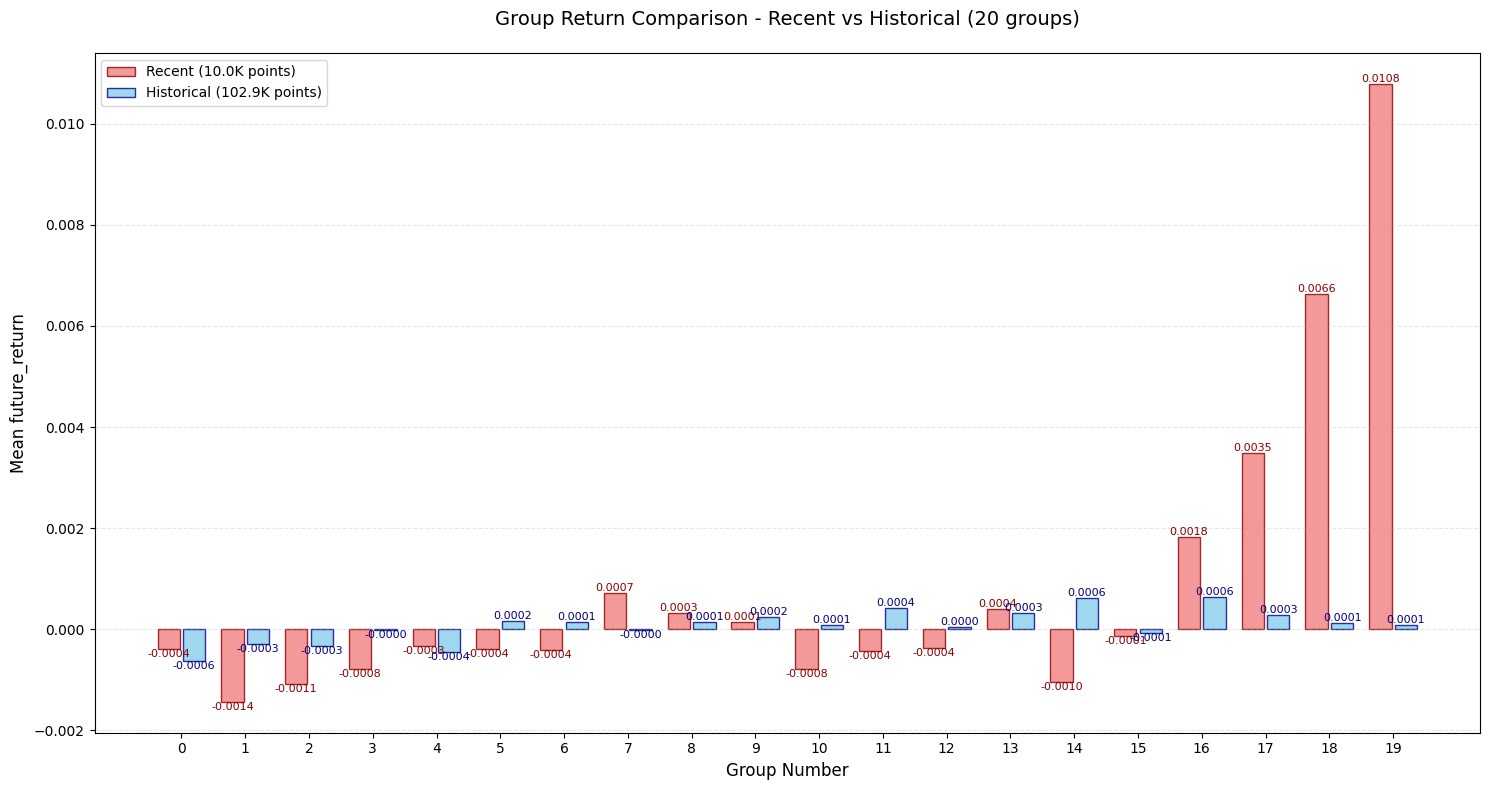

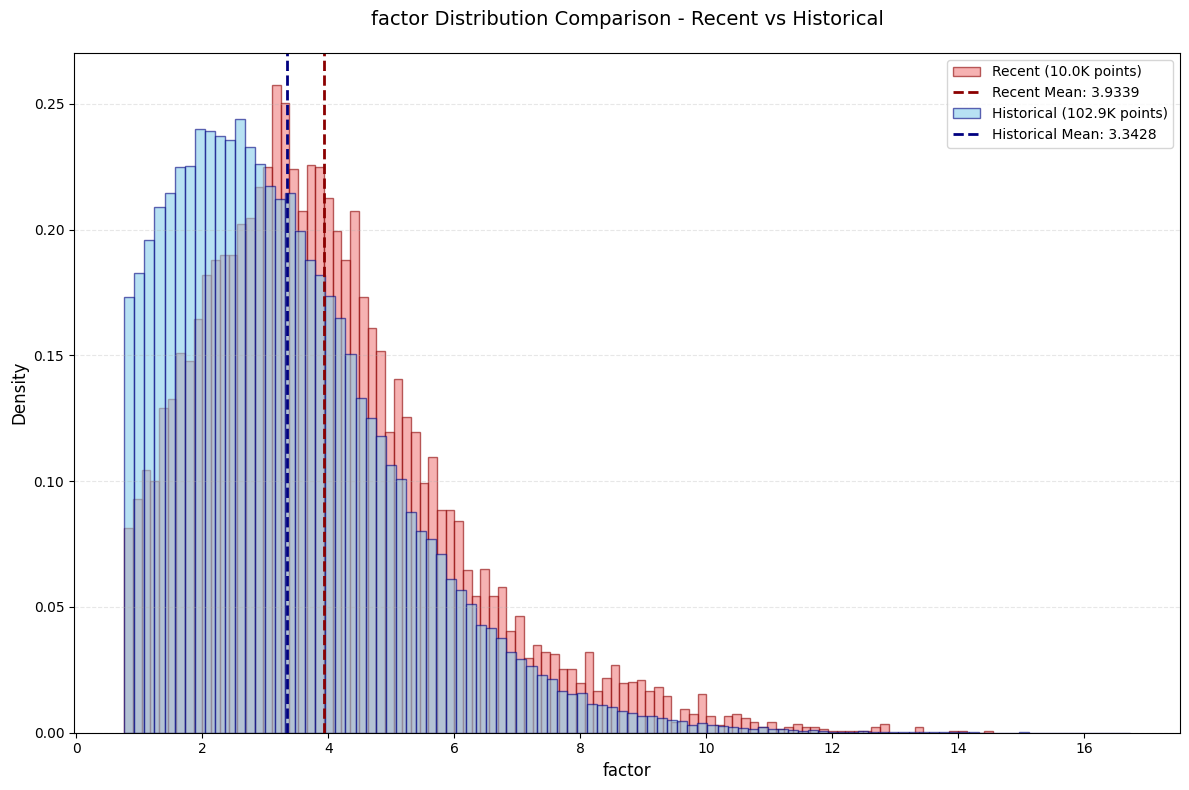

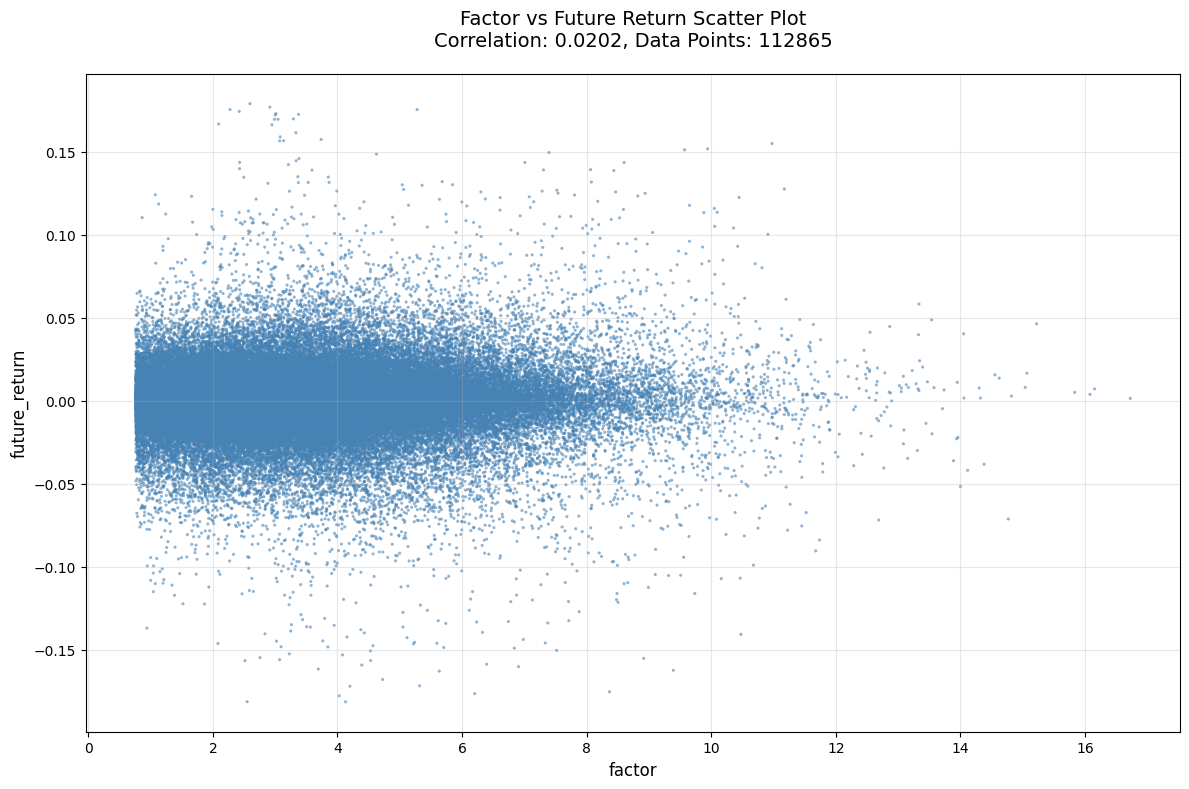

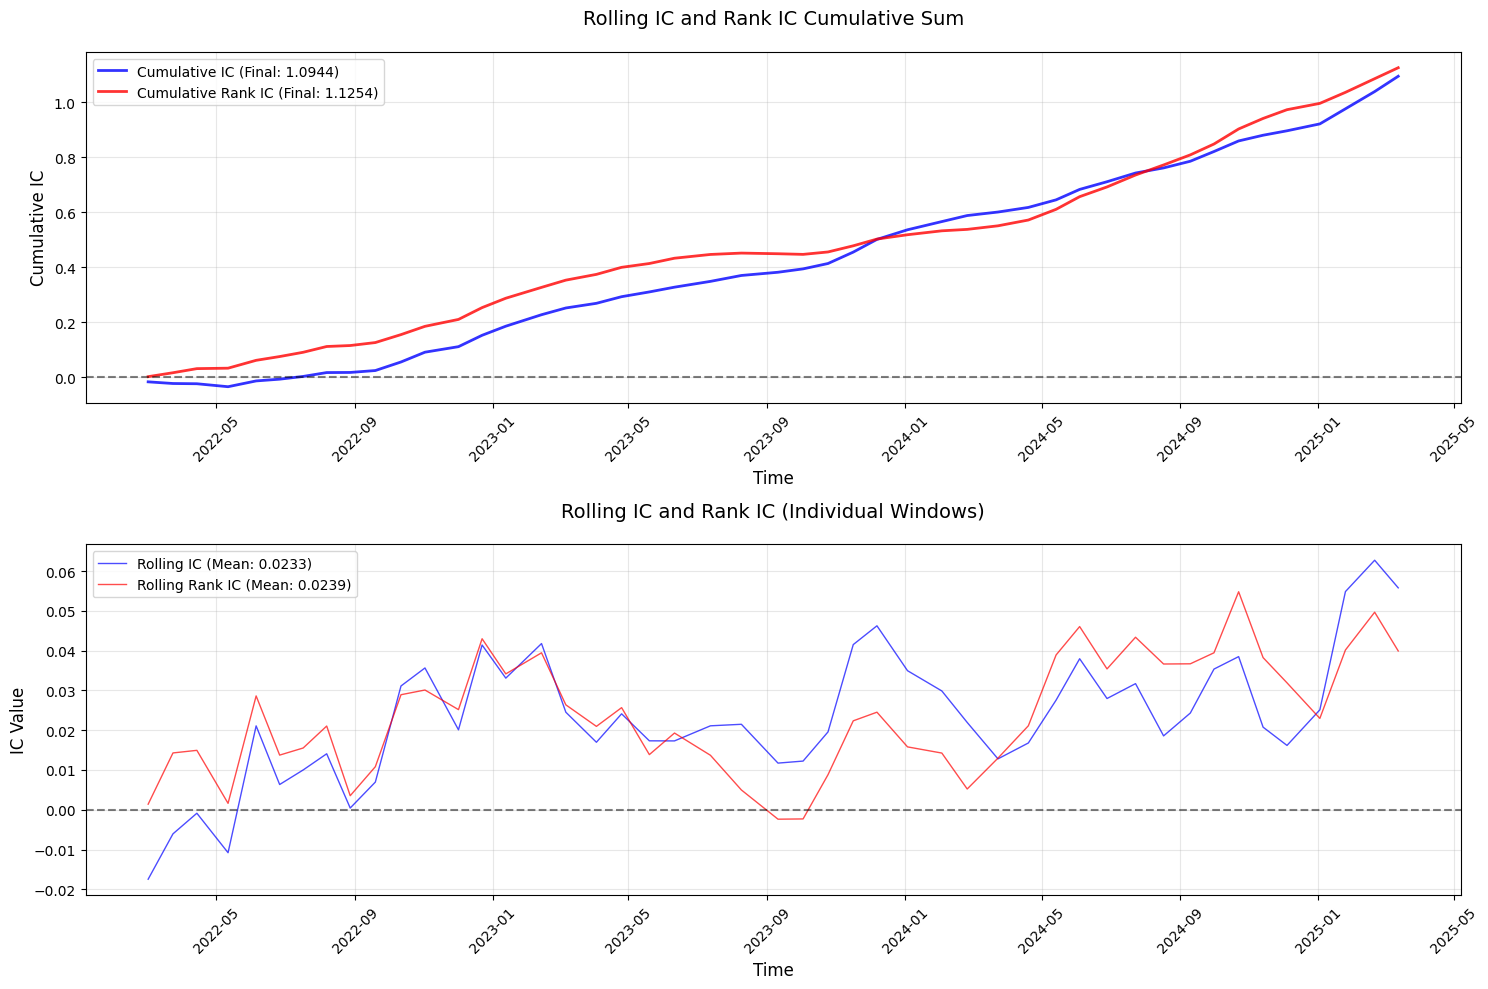

‚úÖ Â∑≤ÊòæÁ§∫ 4 ‰∏™ÂõæÁâá
----------------------------------------


In [193]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=True)

In [194]:
from tabulate import tabulate

def display_factor_evaluation(result):
    # 1. Âü∫Á°ÄÁªüËÆ°ÊåáÊ†á
    basic_metrics = [
        ["‰ø°ÊÅØÁ≥ªÊï∞(IC)", result['correlation_analysis']['IC']],
        ["Áß©Áõ∏ÂÖ≥Á≥ªÊï∞(Rank IC)", result['correlation_analysis']['Rank_IC']],
        ["‰ø°ÊÅØÊØîÁéá(IR)", result['information_ratio']['IR']],
        ["ÂàÜÁªÑÊï∞Èáè", result['information_ratio']['n_groups']],
        ["Êï∞ÊçÆÁÇπÊï∞", f"{result['factor_return_scatter']['data_points']:,}"],
        ["ÂºÇÂ∏∏ÂÄº(>3œÉ)", f"{result['factor_distribution']['outlier_analysis']['>3std']*100:.2f}%"],
        ["ÂºÇÂ∏∏ÂÄº(>5œÉ)", f"{result['factor_distribution']['outlier_analysis']['>5std']*100:.2f}%"]
    ]
    
    # 2. ÂàÜÁªÑÂàÜÊûê
    group_stats = result['group_analysis']['group_stats']
    group_table = []
    for idx, row in group_stats.iterrows():
        group_table.append([
            idx,
            f"{row['val_min']:.4f}",
            f"{row['val_max']:.4f}",
            f"{row['val_mean']:.4f}",
            f"{row['return_mean']:.6f}",
            f"{row['return_std']:.4f}",
            row['count']
        ])
    
    # 3. Âõ†Â≠êÂàÜÂ∏ÉÊèèËø∞
    dist_stats = result['factor_distribution']['descriptive_stats']
    distribution_metrics = [
        ["ÂùáÂÄº", f"{dist_stats['mean']:.4f}"],
        ["Ê†áÂáÜÂ∑Æ", f"{dist_stats['std']:.4f}"],
        ["ÊúÄÂ∞èÂÄº", f"{dist_stats['min']:.4f}"],
        ["1%ÂàÜ‰ΩçÊï∞", f"{dist_stats['1%']:.4f}"],
        ["5%ÂàÜ‰ΩçÊï∞", f"{dist_stats['5%']:.4f}"],
        ["25%ÂàÜ‰ΩçÊï∞", f"{dist_stats['25%']:.4f}"],
        ["‰∏≠‰ΩçÊï∞", f"{dist_stats['50%']:.4f}"],
        ["75%ÂàÜ‰ΩçÊï∞", f"{dist_stats['75%']:.4f}"],
        ["95%ÂàÜ‰ΩçÊï∞", f"{dist_stats['95%']:.4f}"],
        ["99%ÂàÜ‰ΩçÊï∞", f"{dist_stats['99%']:.4f}"],
        ["ÊúÄÂ§ßÂÄº", f"{dist_stats['max']:.4f}"]
    ]
    
    # 4. ÂàÜÁªÑÁõ∏ÂÖ≥ÊÄß
    group_correlations = []
    for i, corr in enumerate(result['information_ratio']['group_correlations']):
        group_correlations.append([f"ÁªÑ {i+1}", f"{corr:.6f}"])
    
    # 5. ÊªöÂä®ICÂàÜÊûê - ÂÆåÊï¥Â±ïÁ§∫
    rolling_ic = result['rolling_ic_analysis']['rolling_ic']
    rolling_rank_ic = result['rolling_ic_analysis']['rolling_rank_ic']
    window_centers = result['rolling_ic_analysis']['window_centers']
    cumsum_ic = result['rolling_ic_analysis']['cumsum_ic']
    cumsum_rank_ic = result['rolling_ic_analysis']['cumsum_rank_ic']
    
    # ÂàõÂª∫ÊªöÂä®ICÊï∞ÊçÆË°®Ê†º
    rolling_table = []
    for i in range(len(rolling_ic)):
        rolling_table.append([
            window_centers[i].strftime('%Y-%m-%d %H:%M:%S'),
            f"{rolling_ic[i]:.6f}",
            f"{rolling_rank_ic[i]:.6f}",
            f"{cumsum_ic[i]:.6f}",
            f"{cumsum_rank_ic[i]:.6f}"
        ])
    
    # ÊªöÂä®ICÊ±áÊÄªÁªüËÆ°
    rolling_metrics = [
        ["ÊªöÂä®ICÂùáÂÄº", f"{pd.Series(rolling_ic).mean():.6f}"],
        ["ÊªöÂä®ICÊ†áÂáÜÂ∑Æ", f"{pd.Series(rolling_ic).std():.6f}"],
        ["ÊªöÂä®Rank ICÂùáÂÄº", f"{pd.Series(rolling_rank_ic).mean():.6f}"],
        ["ÊªöÂä®Rank ICÊ†áÂáÜÂ∑Æ", f"{pd.Series(rolling_rank_ic).std():.6f}"],
        ["Á¥ØÁßØICÁªàÂÄº", f"{cumsum_ic[-1]:.6f}"],
        ["Á¥ØÁßØRank ICÁªàÂÄº", f"{cumsum_rank_ic[-1]:.6f}"],
        ["ÂàùÂßãÁ™óÂè£Â§ßÂ∞è", result['rolling_ic_analysis']['initial_window']],
        ["ÊªöÂä®Ê≠•Èïø", result['rolling_ic_analysis']['rolling_step']]
    ]
    
    # 6. Êó∂Èó¥Á™óÂè£ÁªüËÆ°
    window_stats = []
    window_data = result['factor_distribution']['window_stats'][10]
    
    # Ê≠£Á°ÆÂ§ÑÁêÜÊó∂Èó¥Á™óÂè£ÁªüËÆ°Êï∞ÊçÆ
    if isinstance(window_data['stats'], pd.DataFrame):
        # Â¶ÇÊûúÊòØDataFrameÁªìÊûÑ
        for idx, row in window_data['stats'].iterrows():
            window_stats.append([
                idx,
                f"{row['mean']:.4f}",
                f"{row['std']:.4f}",
                f"{row['skew']:.4f}",
                f"{row['lambda']:.4f}",
                row['count']
            ])
    else:
        # Â¶ÇÊûúÊòØÂ≠óÂÖ∏ÁªìÊûÑ
        for time_range, stats in window_data['stats'].items():
            window_stats.append([
                time_range,
                f"{stats['mean']:.4f}",
                f"{stats['std']:.4f}",
                f"{stats['skew']:.4f}",
                f"{stats['lambda']:.4f}",
                stats['count']
            ])
    
    # # 7. Âπ≥Á®≥ÊÄßÊµãËØïÁªìÊûú
    # stationarity = result['stationarity_test']
    # stationarity_metrics = [
    #     ["ADFÁªüËÆ°Èáè", stationarity['adf_statistic']],
    #     ["PÂÄº", stationarity['p_value']],
    #     ["1%‰∏¥ÁïåÂÄº", stationarity['critical_values']['1%']],
    #     ["5%‰∏¥ÁïåÂÄº", stationarity['critical_values']['5%']],
    #     ["10%‰∏¥ÁïåÂÄº", stationarity['critical_values']['10%']],
    #     ["ÊòØÂê¶Âπ≥Á®≥", stationarity['is_stationary']],
    #     #["ÊòæËëóÊÄßÊ∞¥Âπ≥", stationarity['alpha']]
    # ]
    
    # ÊâìÂç∞ÊâÄÊúâÁªìÊûú
    print("="*80)
    print("Âõ†Â≠êËØÑ‰º∞Ê†∏ÂøÉÊåáÊ†á".center(80))
    print("="*80)
    print(tabulate(basic_metrics, headers=["ÊåáÊ†á", "ÂÄº"], tablefmt="grid", floatfmt=".6f"))
    
    # print("\n" + "="*80)
    # print("Âπ≥Á®≥ÊÄßÊµãËØïÁªìÊûú".center(80))
    # print("="*80)
    # print(tabulate(stationarity_metrics, headers=["ÊåáÊ†á", "ÂÄº"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("ÂàÜÁªÑÂàÜÊûêÁªìÊûú".center(80))
    print("="*80)
    print(tabulate(group_table, headers=["ÂàÜÁªÑ", "ÊúÄÂ∞èÂÄº", "ÊúÄÂ§ßÂÄº", "Âπ≥ÂùáÂÄº", "Êî∂ÁõäÂùáÂÄº", "Êî∂ÁõäÊ†áÂáÜÂ∑Æ", "Ê†∑Êú¨Êï∞"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("Âõ†Â≠êÂàÜÂ∏ÉÁªüËÆ°".center(80))
    print("="*80)
    print(tabulate(distribution_metrics, headers=["ÁªüËÆ°Èáè", "ÂÄº"], tablefmt="grid", floatfmt=".4f"))
    
    print("\n" + "="*80)
    print("ÂàÜÁªÑÁõ∏ÂÖ≥ÊÄß".center(80))
    print("="*80)
    print(tabulate(group_correlations, headers=["ÂàÜÁªÑ", "Áõ∏ÂÖ≥ÊÄß"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("ÊªöÂä®ICÂàÜÊûêÊ±áÊÄª".center(80))
    print("="*80)
    print(tabulate(rolling_metrics, headers=["ÊåáÊ†á", "ÂÄº"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("ÊªöÂä®ICËØ¶ÁªÜÊï∞ÊçÆ".center(80))
    print("="*80)
    print(tabulate(rolling_table, headers=["Á™óÂè£‰∏≠ÂøÉ", "ÊªöÂä®IC", "ÊªöÂä®Rank IC", "Á¥ØÁßØIC", "Á¥ØÁßØRank IC"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("Êó∂Èó¥Á™óÂè£ÁªüËÆ°".center(80))
    print("="*80)
    print(tabulate(window_stats, headers=["Êó∂Èó¥Á™óÂè£", "ÂùáÂÄº", "Ê†áÂáÜÂ∑Æ", "ÂÅèÂ∫¶", "Lambda", "Ê†∑Êú¨Êï∞"], tablefmt="grid"))
    print(f"Êó∂Èó¥ËåÉÂõ¥: {window_data['time_ranges']}")

# Ë∞ÉÁî®Â±ïÁ§∫ÂáΩÊï∞
display_factor_evaluation(result)

                                    Âõ†Â≠êËØÑ‰º∞Ê†∏ÂøÉÊåáÊ†á                                    
+---------------------+----------------------+
| ÊåáÊ†á                | ÂÄº                   |
+=====================+======================+
| ‰ø°ÊÅØÁ≥ªÊï∞(IC)        | 0.020158529388120055 |
+---------------------+----------------------+
| Áß©Áõ∏ÂÖ≥Á≥ªÊï∞(Rank IC) | 0.023357122480376878 |
+---------------------+----------------------+
| ‰ø°ÊÅØÊØîÁéá(IR)        | 0.4501157843521072   |
+---------------------+----------------------+
| ÂàÜÁªÑÊï∞Èáè            | 10                   |
+---------------------+----------------------+
| Êï∞ÊçÆÁÇπÊï∞            | 112,865              |
+---------------------+----------------------+
| ÂºÇÂ∏∏ÂÄº(>3œÉ)         | 12.78%               |
+---------------------+----------------------+
| ÂºÇÂ∏∏ÂÄº(>5œÉ)         | 0.92%                |
+---------------------+----------------------+

                                     ÂàÜÁªÑÂàÜÊûêÁªìÊûú                